<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/var/folders/rs/b530ln852hdbv8t2r88xn_kh0000gn/T/ipykernel_12527/1906903308.py:10: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(url, sep='\s+') # warns for separator but works?


Optimal smoothing parameter for males:    22.6
Optimal smoothing parameter for females:  25.900000000000006
Optimal smoothing parameter for combined: 48.50000000000001


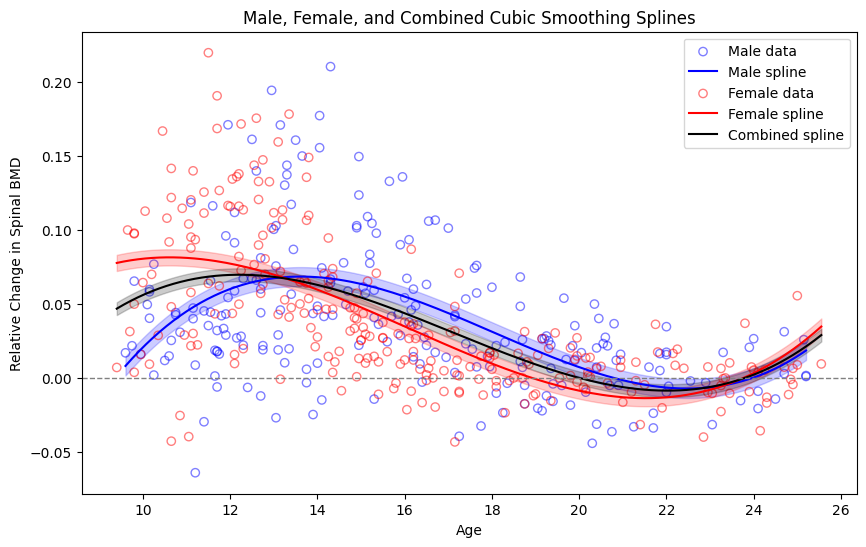

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# easiest way to get the data...
url = "https://hastie.su.domains/ElemStatLearn/datasets/bone.data"
data = pd.read_csv(url, sep='\s+') # warns for separator but works?

# data columns: idnum, age, gender, spnbmd
male_data = data[data['gender'] == 'male'].copy()
female_data = data[data['gender'] == 'female'].copy()

# compute an optimal smoothing parameter via CV, fit the spline, then find the CI
def fit_smoothing_spline_cv(x, y, s_candidates=None, n_splits=10):
    order = np.argsort(x)
    x = x[order]
    y = y[order]

    n = len(x)
    if s_candidates is None:
        s_candidates = np.logspace(np.log10(0.1 * n), np.log10(10 * n), 20)

    # CV to find best s
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_errors = []
    for s_val in s_candidates:
        fold_mse = []
        for train_idx, test_idx in kf.split(x):
            x_train, x_test = x[train_idx], x[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            spline = UnivariateSpline(x_train, y_train, s=s_val)
            y_pred = spline(x_test)
            fold_mse.append(mean_squared_error(y_test, y_pred))
        cv_errors.append(np.mean(fold_mse))

    best_s = s_candidates[np.argmin(cv_errors)]
    spline_final = UnivariateSpline(x, y, s=best_s)

    # generate coordinates for the spline
    x_grid = np.linspace(x.min(), x.max(), 200)
    y_fit = spline_final(x_grid)

    # find CIs
    residuals = y - spline_final(x)
    sigma2 = np.mean(residuals**2)

    # approximate the df
    df_eff = len(spline_final.get_knots())
    h = df_eff / n
    se_approx = np.sqrt(sigma2 * h)

    # 90% CI
    ci_lower = y_fit - 1.645 * se_approx
    ci_upper = y_fit + 1.645 * se_approx

    return spline_final, best_s, x_grid, y_fit, ci_lower, ci_upper

#fit the splines to male, female, and all data since 5.6 has both...
spline_male, best_s_male, x_grid_m, y_fit_m, ci_lower_m, ci_upper_m = fit_smoothing_spline_cv(
    male_data['age'].values, male_data['spnbmd'].values)
spline_female, best_s_female, x_grid_f, y_fit_f, ci_lower_f, ci_upper_f = fit_smoothing_spline_cv(
    female_data['age'].values, female_data['spnbmd'].values)
spline_both, best_s_both, x_grid_b, y_fit_b, ci_lower_b, ci_upper_b = fit_smoothing_spline_cv(
    data['age'].values, data['spnbmd'].values)

print(f"Optimal smoothing parameter for males:    {best_s_male}")
print(f"Optimal smoothing parameter for females:  {best_s_female}")
print(f"Optimal smoothing parameter for combined: {best_s_both}")

# plotting
plt.figure(figsize=(10, 6))

plt.scatter(male_data['age'], male_data['spnbmd'],
            facecolors='none', edgecolors='blue', alpha=0.5, label='Male data')
plt.plot(x_grid_m, y_fit_m, color='blue', label='Male spline')
plt.fill_between(x_grid_m, ci_lower_m, ci_upper_m, color='blue', alpha=0.2)

plt.scatter(female_data['age'], female_data['spnbmd'],
            facecolors='none', edgecolors='red', alpha=0.5, label='Female data')
plt.plot(x_grid_f, y_fit_f, color='red', label='Female spline')
plt.fill_between(x_grid_f, ci_lower_f, ci_upper_f, color='red', alpha=0.2)

# just the spline for both (scatters are already colored)
plt.plot(x_grid_b, y_fit_b, color='black', label='Combined spline')
plt.fill_between(x_grid_b, ci_lower_b, ci_upper_b, color='black', alpha=0.2)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Age')
plt.ylabel('Relative Change in Spinal BMD')
plt.title('Male, Female, and Combined Cubic Smoothing Splines')
plt.legend()
plt.show()